图已创建。
总节点数: 25
左上角节点 (0, 0) 对应的整数节点为: 0
右下角节点 (4, 4) 对应的整数节点为: 24
使用 '坐标即嵌入' 方法生成嵌入。

开始路径搜索...
起点: Node 0 (坐标 (0, 0))
终点: Node 23 (坐标 (4, 3))
目标节点 23 在邻居中，直接选择。

搜索完成。
找到的路径: [0, 5, 10, 11, 16, 17, 22, 23]


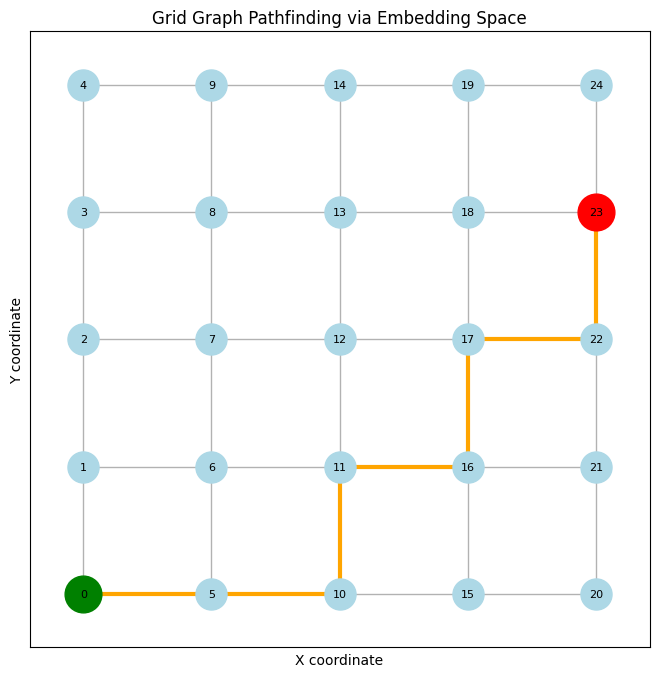

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

def create_grid_graph_with_int_labels(grid_size=(5, 5)):
    """
    创建一个网格图，并将节点标签转换为整数。

    Args:
        grid_size (tuple): 网格的尺寸 (rows, cols).

    Returns:
        tuple: 包含以下元素的元组:
            - G_int (nx.Graph): 节点为整数的图.
            - node_to_coord (dict): 整数节点到其原始坐标的映射.
            - coord_to_node (dict): 原始坐标到其整数节点的映射.
    """
    rows, cols = grid_size
    # 1. 创建一个带有坐标作为节点的图，例如 (0, 0), (0, 1) ...
    G = nx.grid_2d_graph(rows, cols)

    # 2. 获取节点列表并创建整数标签的映射
    # nx.convert_node_labels_to_integers 会创建一个新的图
    # mapping参数可以捕获从旧标签到新标签的映射
    # 我们需要的是从新标签(int)到旧标签(coord)的映射，所以我们反转它
    int_to_coord_map = {}
    G_int = nx.convert_node_labels_to_integers(
        G,
        first_label=0,
        ordering="default",
        label_attribute="old_label" # 将旧标签存储在'old_label'属性中
    )
    # 从新图的属性中构建映射
    node_to_coord = nx.get_node_attributes(G_int, 'old_label')
    coord_to_node = {v: k for k, v in node_to_coord.items()}
    
    # 3. 创建邻接字典
    adj = {node: list(neighbors) for node, neighbors in G_int.adjacency()}
    
    print("图已创建。")
    print(f"总节点数: {G_int.number_of_nodes()}")
    print(f"左上角节点 (0, 0) 对应的整数节点为: {coord_to_node[(0, 0)]}")
    print(f"右下角节点 { (rows-1, cols-1)} 对应的整数节点为: {coord_to_node[ (rows-1, cols-1)]}")
    
    return G_int, adj, node_to_coord, coord_to_node

def generate_embeddings(graph, node_to_coord, method='coordinates'):
    """
    为图中的所有节点生成嵌入。

    Args:
        graph (nx.Graph): 输入的图。
        node_to_coord (dict): 节点到坐标的映射。
        method (str): 'coordinates' 或 'spectral'。

    Returns:
        np.ndarray: 一个 N x D 的NumPy数组，N是节点数，D是嵌入维度。
    """
    num_nodes = graph.number_of_nodes()
    
    if method == 'coordinates':
        print("使用 '坐标即嵌入' 方法生成嵌入。")
        # 嵌入维度为2
        embedding_dim = 2
        embeddings = np.zeros((num_nodes, embedding_dim))
        for node, coord in node_to_coord.items():
            embeddings[node] = coord
        return embeddings
        
    elif method == 'spectral':
        print("使用 '谱嵌入' 方法生成嵌入。")
        # nx.spectral_layout返回一个字典 {node: [x, y]}
        pos = nx.spectral_layout(graph)
        # 确保嵌入矩阵的行索引与节点索引一致
        embeddings = np.array([pos[i] for i in sorted(pos.keys())])
        return embeddings
        
    else:
        raise ValueError("未知的方法: {method}. 请选择 'coordinates' 或 'spectral'.")

def find_path_in_embedding_space(adj, embeddings, start_node, target_node):
    """
    在嵌入空间中通过贪婪算法寻找路径。

    Args:
        adj (dict): 图的邻接表。
        embeddings (np.ndarray): 节点嵌入矩阵。
        start_node (int): 起始节点。
        target_node (int): 目标节点。

    Returns:
        list: 从起点到终点的节点路径列表。
    """
    if start_node == target_node:
        return [start_node]

    path = [start_node]
    current_node = start_node
    
    # 设置最大步数以防陷入死循环（对于某些复杂图和嵌入可能发生）
    max_steps = embeddings.shape[0] * 2 

    for _ in range(max_steps):
        # 如果当前节点就是目标，结束搜索
        if current_node == target_node:
            print("已到达目标节点。")
            break
            
        neighbors = adj[current_node]
        
        # 规则：如果目标节点在邻居中，直接选择它
        if target_node in neighbors:
            path.append(target_node)
            current_node = target_node
            print(f"目标节点 {target_node} 在邻居中，直接选择。")
            break

        # 1. 计算当前位置到目标位置的“目标向量”
        target_vector = embeddings[target_node] - embeddings[current_node]
        
        best_neighbor = -1
        max_similarity = -np.inf # 使用余弦相似度，范围是[-1, 1]

        # 2. 遍历所有邻居，找到与“目标向量”最接近的“移动向量”
        for neighbor in neighbors:
            # 避免走回头路（简单策略）
            if len(path) > 1 and neighbor == path[-2]:
                continue

            # 3. 计算从当前节点到邻居的“移动向量”
            move_vector = embeddings[neighbor] - embeddings[current_node]
            
            # 4. 计算余弦相似度
            # A·B / (|A| * |B|)
            cosine_similarity = np.dot(target_vector, move_vector) / \
                                (np.linalg.norm(target_vector) * np.linalg.norm(move_vector))
            
            if cosine_similarity > max_similarity:
                max_similarity = cosine_similarity
                best_neighbor = neighbor
        
        if best_neighbor == -1:
            print("警告：找不到合适的下一步，路径搜索可能失败。")
            break
            
        # 5. 选择最佳邻居作为下一步
        current_node = best_neighbor
        path.append(current_node)
        
    # 检查是否成功找到路径
    if path[-1] != target_node:
        print(f"未能在 {max_steps} 步内找到通往目标 {target_node} 的完整路径。")
    
    return path

def visualize_path(G, pos, path, start_node, target_node):
    """
    可视化图、节点和找到的路径。
    """
    plt.figure(figsize=(8, 8))
    
    # 绘制所有节点和边
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    # 高亮起点和终点
    nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color='green', node_size=700, label="Start")
    nx.draw_networkx_nodes(G, pos, nodelist=[target_node], node_color='red', node_size=700, label="Target")
    
    # 绘制路径
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='orange', width=3.0)
    
    plt.title("Grid Graph Pathfinding via Embedding Space")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.show()


# --- 主程序 ---
if __name__ == "__main__":
    GRID_SIZE = (5, 5)
    
    # 1. 创建图
    G, adj, node_to_coord, coord_to_node = create_grid_graph_with_int_labels(GRID_SIZE)
    
    # 2. 生成嵌入
    # 你可以在这里切换 'coordinates' 和 'spectral' 来观察不同
    embeddings = generate_embeddings(G, node_to_coord, method='coordinates')
    
    # 3. 设定起点和终点
    # start_coord = (0, 0) # 左上角
    # target_coord = (GRID_SIZE[0] - 1, GRID_SIZE[1] - 1) # 右下角
    start_coord = (0,0)
    target_coord = (4,3)
    
    
    start_node = coord_to_node[start_coord]
    target_node = coord_to_node[target_coord]
    
    print(f"\n开始路径搜索...")
    print(f"起点: Node {start_node} (坐标 {start_coord})")
    print(f"终点: Node {target_node} (坐标 {target_coord})")
    
    # 4. 寻找路径
    found_path = find_path_in_embedding_space(adj, embeddings, start_node, target_node)
    
    print(f"\n搜索完成。")
    print(f"找到的路径: {found_path}")
    
    # 5. 可视化结果
    # 使用节点坐标作为绘图布局，以获得直观的网格视图
    pos = {node: coord for node, coord in node_to_coord.items()}
    visualize_path(G, pos, found_path, start_node, target_node)

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
# --- GAE 实现所需的新库 ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
warnings.filterwarnings("ignore", category=UserWarning)

# --- GAE 模型定义 ---
class GAE(nn.Module):
    """
    一个简单的图自编码器模型，使用GCN作为编码器
    """
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GAE, self).__init__()
        # 编码器包含两个GCN层
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        # 使用ReLU作为激活函数
        x = F.relu(self.conv1(x, edge_index))
        # 第二层输出即为嵌入，不加激活函数
        return self.conv2(x, edge_index)

    def decode(self, z):
        # 通过内积重构邻接矩阵
        adj_recon = torch.sigmoid(torch.matmul(z, z.t()))
        return adj_recon

def create_grid_graph_with_int_labels(grid_size=(5, 5)):
    """
    创建一个网格图，并将节点标签转换为整数。

    Args:
        grid_size (tuple): 网格的尺寸 (rows, cols).

    Returns:
        tuple: 包含以下元素的元组:
            - G_int (nx.Graph): 节点为整数的图.
            - node_to_coord (dict): 整数节点到其原始坐标的映射.
            - coord_to_node (dict): 原始坐标到其整数节点的映射.
    """
    rows, cols = grid_size
    # 1. 创建一个带有坐标作为节点的图，例如 (0, 0), (0, 1) ...
    G = nx.grid_2d_graph(rows, cols)

    # 2. 获取节点列表并创建整数标签的映射
    # nx.convert_node_labels_to_integers 会创建一个新的图
    # mapping参数可以捕获从旧标签到新标签的映射
    # 我们需要的是从新标签(int)到旧标签(coord)的映射，所以我们反转它
    int_to_coord_map = {}
    G_int = nx.convert_node_labels_to_integers(
        G,
        first_label=0,
        ordering="default",
        label_attribute="old_label" # 将旧标签存储在'old_label'属性中
    )
    # 从新图的属性中构建映射
    node_to_coord = nx.get_node_attributes(G_int, 'old_label')
    coord_to_node = {v: k for k, v in node_to_coord.items()}
    
    # 3. 创建邻接字典
    adj = {node: list(neighbors) for node, neighbors in G_int.adjacency()}
    
    print("图已创建。")
    print(f"总节点数: {G_int.number_of_nodes()}")
    print(f"左上角节点 (0, 0) 对应的整数节点为: {coord_to_node[(0, 0)]}")
    print(f"右下角节点 { (rows-1, cols-1)} 对应的整数节点为: {coord_to_node[ (rows-1, cols-1)]}")
    
    return G_int, adj, node_to_coord, coord_to_node


# --- 嵌入生成函数 (核心修改) ---
def generate_embeddings_gae(graph, method='gae', **kwargs):
    """
    为图中的所有节点生成嵌入。现在支持 'gae'。

    Args:
        graph (nx.Graph): 输入的图。
        method (str): 'gae'。
        **kwargs: 传递给嵌入模型的额外参数。

    Returns:
        np.ndarray: 一个 N x D 的NumPy数组，N是节点数，D是嵌入维度。
    """
    if method == 'gae':
        print("使用 'GAE' 方法生成嵌入。")
        
        # --- 1. GAE 超参数 ---
        embedding_dim = kwargs.get('embedding_dim', 32)
        hidden_dim = kwargs.get('hidden_dim', 64)
        epochs = kwargs.get('epochs', 200)
        lr = kwargs.get('lr', 0.01)
        
        # --- 2. 数据准备 ---
        # 将 networkx 图转换为 PyG 的 Data 对象
        pyg_data = from_networkx(graph)
        num_nodes = graph.number_of_nodes()
        
        # 因为我们的图没有初始节点特征，所以使用单位矩阵作为特征
        # 这让模型纯粹从图结构中学习
        pyg_data.x = torch.eye(num_nodes)
        
        # 准备用于计算损失的邻接矩阵真值
        adj_label = torch.tensor(nx.to_numpy_array(graph), dtype=torch.float)
        
        # --- 3. 模型和优化器 ---
        model = GAE(
            in_channels=num_nodes,      # 输入维度等于节点数 (因为用单位矩阵作特征)
            hidden_channels=hidden_dim, # 中间层维度
            out_channels=embedding_dim  # 输出维度即嵌入维度
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # --- 4. 训练循环 ---
        print(f"开始训练GAE... (epochs={epochs}, lr={lr})")
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            
            # 编码器生成嵌入
            z = model.encode(pyg_data.x, pyg_data.edge_index)
            
            # 解码器重构邻接矩阵
            adj_recon = model.decode(z)
            
            # 计算重构损失 (二元交叉熵损失)
            loss = F.binary_cross_entropy(adj_recon, adj_label)
            
            loss.backward()
            optimizer.step()
            
            if (epoch + 1) % 20 == 0:
                print(f'Epoch: {epoch+1:03d}, Loss: {loss.item():.4f}')
                
        # --- 5. 获取最终嵌入 ---
        print("训练完成。正在提取嵌入。")
        model.eval()
        with torch.no_grad():
            final_embeddings = model.encode(pyg_data.x, pyg_data.edge_index)
        
        # 将 Pytorch Tensor 转换为 Numpy 数组
        return final_embeddings.cpu().numpy()
        
    else:
        raise ValueError(f"未知的方法: {method}. 此版本仅支持 'gae'.")
    
def generate_embeddings(graph, node_to_coord, method='coordinates'):
    """
    为图中的所有节点生成嵌入。

    Args:
        graph (nx.Graph): 输入的图。
        node_to_coord (dict): 节点到坐标的映射。
        method (str): 'coordinates' 或 'spectral'。

    Returns:
        np.ndarray: 一个 N x D 的NumPy数组，N是节点数，D是嵌入维度。
    """
    num_nodes = graph.number_of_nodes()
    
    if method == 'coordinates':
        print("使用 '坐标即嵌入' 方法生成嵌入。")
        # 嵌入维度为2
        embedding_dim = 2
        embeddings = np.zeros((num_nodes, embedding_dim))
        for node, coord in node_to_coord.items():
            embeddings[node] = coord
        return embeddings
        
    elif method == 'spectral':
        print("使用 '谱嵌入' 方法生成嵌入。")
        # nx.spectral_layout返回一个字典 {node: [x, y]}
        pos = nx.spectral_layout(graph)
        # 确保嵌入矩阵的行索引与节点索引一致
        embeddings = np.array([pos[i] for i in sorted(pos.keys())])
        return embeddings
        
    else:
        raise ValueError("未知的方法: {method}. 请选择 'coordinates' 或 'spectral'.")

def find_path_in_embedding_space(adj, embeddings, start_node, target_node):
    """
    在嵌入空间中通过贪婪算法寻找路径。

    Args:
        adj (dict): 图的邻接表。
        embeddings (np.ndarray): 节点嵌入矩阵。
        start_node (int): 起始节点。
        target_node (int): 目标节点。

    Returns:
        list: 从起点到终点的节点路径列表。
    """
    if start_node == target_node:
        return [start_node]

    path = [start_node]
    current_node = start_node
    
    # 设置最大步数以防陷入死循环（对于某些复杂图和嵌入可能发生）
    max_steps = embeddings.shape[0] * 2 

    for _ in range(max_steps):
        # 如果当前节点就是目标，结束搜索
        if current_node == target_node:
            print("已到达目标节点。")
            break
            
        neighbors = adj[current_node]
        
        # 规则：如果目标节点在邻居中，直接选择它
        if target_node in neighbors:
            path.append(target_node)
            current_node = target_node
            print(f"目标节点 {target_node} 在邻居中，直接选择。")
            break

        # 1. 计算当前位置到目标位置的“目标向量”
        target_vector = embeddings[target_node] - embeddings[current_node]
        
        best_neighbor = -1
        max_similarity = -np.inf # 使用余弦相似度，范围是[-1, 1]

        # 2. 遍历所有邻居，找到与“目标向量”最接近的“移动向量”
        for neighbor in neighbors:
            # 避免走回头路（简单策略）
            if len(path) > 1 and neighbor == path[-2]:
                continue

            # 3. 计算从当前节点到邻居的“移动向量”
            move_vector = embeddings[neighbor] - embeddings[current_node]
            
            # 4. 计算余弦相似度
            # A·B / (|A| * |B|)
            cosine_similarity = np.dot(target_vector, move_vector) / \
                                (np.linalg.norm(target_vector) * np.linalg.norm(move_vector))
            
            if cosine_similarity > max_similarity:
                max_similarity = cosine_similarity
                best_neighbor = neighbor
        
        if best_neighbor == -1:
            print("警告：找不到合适的下一步，路径搜索可能失败。")
            break
            
        # 5. 选择最佳邻居作为下一步
        current_node = best_neighbor
        path.append(current_node)
        
    # 检查是否成功找到路径
    if path[-1] != target_node:
        print(f"未能在 {max_steps} 步内找到通往目标 {target_node} 的完整路径。")
    
    return path

def visualize_path(G, pos, path, start_node, target_node):
    """
    可视化图、节点和找到的路径。
    """
    plt.figure(figsize=(8, 8))
    
    # 绘制所有节点和边
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    # 高亮起点和终点
    nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_color='green', node_size=700, label="Start")
    nx.draw_networkx_nodes(G, pos, nodelist=[target_node], node_color='red', node_size=700, label="Target")
    
    # # 绘制路径
    path_edges = list(zip(path, path[1:]))
    # nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='orange', width=3.0)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='orange')
    
    plt.title("Grid Graph Pathfinding via Embedding Space")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.show()

def create_random_graph(num_nodes=40, k=4, p=0.2):
    """
    创建一个带有小世界特性的随机图。
    
    Args:
        num_nodes (int): 图中的节点数量。
        k (int): 每个节点连接到的近邻数。
        p (float): 重连概率，控制图的随机性。
        
    Returns:
        tuple: (G, adj) 其中G是networkx图对象，adj是邻接字典。
    """
    # 创建Watts-Strogatz小世界图
    G = nx.watts_strogatz_graph(n=num_nodes, k=k, p=p)
    
    # 确保图是连通的
    if not nx.is_connected(G):
        print("生成的图不是连通的，添加额外边以确保连通性...")
        # 获取连通分量
        components = list(nx.connected_components(G))
        # 连接所有连通分量
        for i in range(len(components) - 1):
            # 从每个连通分量中随机选择一个节点
            node1 = np.random.choice(list(components[i]))
            node2 = np.random.choice(list(components[i+1]))
            # 添加一条边连接它们
            G.add_edge(node1, node2)
    
    # 创建邻接字典
    adj = {node: list(neighbors) for node, neighbors in G.adjacency()}
    
    print(f"创建了一个随机图，有 {num_nodes} 个节点和 {G.number_of_edges()} 条边。")
    print(f"平均度数: {sum(dict(G.degree()).values()) / num_nodes:.2f}")
    
    return G, adj

创建了一个随机图，有 100 个节点和 200 条边。
平均度数: 4.00
使用 'GAE' 方法生成嵌入。
开始训练GAE... (epochs=200, lr=0.01)
Epoch: 020, Loss: 0.6928
Epoch: 040, Loss: 0.6852
Epoch: 060, Loss: 0.6736
Epoch: 080, Loss: 0.6665
Epoch: 100, Loss: 0.6634
Epoch: 120, Loss: 0.6610
Epoch: 140, Loss: 0.6589
Epoch: 160, Loss: 0.6576
Epoch: 180, Loss: 0.6556
Epoch: 200, Loss: 0.6538
训练完成。正在提取嵌入。

开始路径搜索...
起点: Node 29
终点: Node 36
未能在 200 步内找到通往目标 36 的完整路径。

搜索完成。
找到的路径: [29, 28, 42, 93, 94, 92, 93, 42, 28, 29, 27, 28, 42, 93, 94, 92, 93, 42, 28, 29, 27, 28, 42, 93, 94, 92, 93, 42, 28, 29, 27, 28, 42, 93, 94, 92, 93, 42, 28, 29, 27, 28, 42, 93, 94, 92, 93, 42, 28, 29, 27, 28, 42, 93, 94, 92, 93, 42, 28, 29, 27, 28, 42, 93, 94, 92, 93, 42, 28, 29, 27, 28, 42, 93, 94, 92, 93, 42, 28, 29, 27, 28, 42, 93, 94, 92, 93, 42, 28, 29, 27, 28, 42, 93, 94, 92, 93, 42, 28, 29, 27, 28, 42, 93, 94, 92, 93, 42, 28, 29, 27, 28, 42, 93, 94, 92, 93, 42, 28, 29, 27, 28, 42, 93, 94, 92, 93, 42, 28, 29, 27, 28, 42, 93, 94, 92, 93, 42, 28, 29, 27, 28, 42,

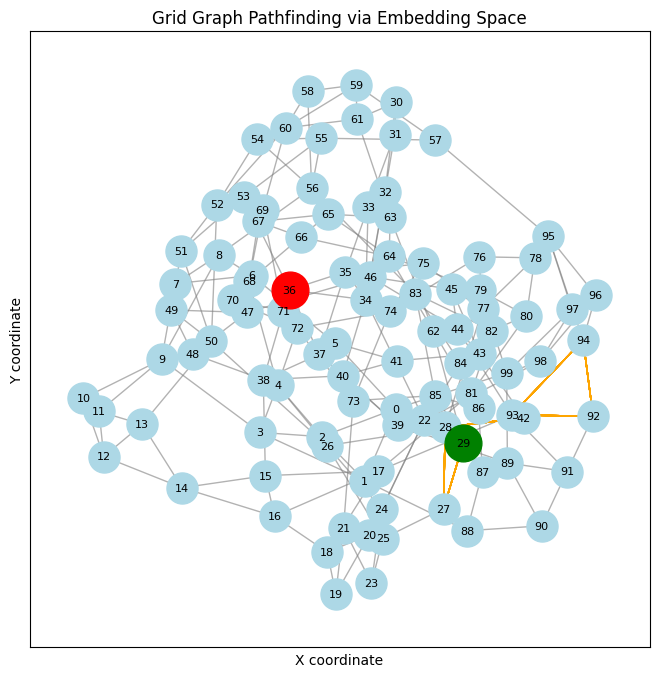

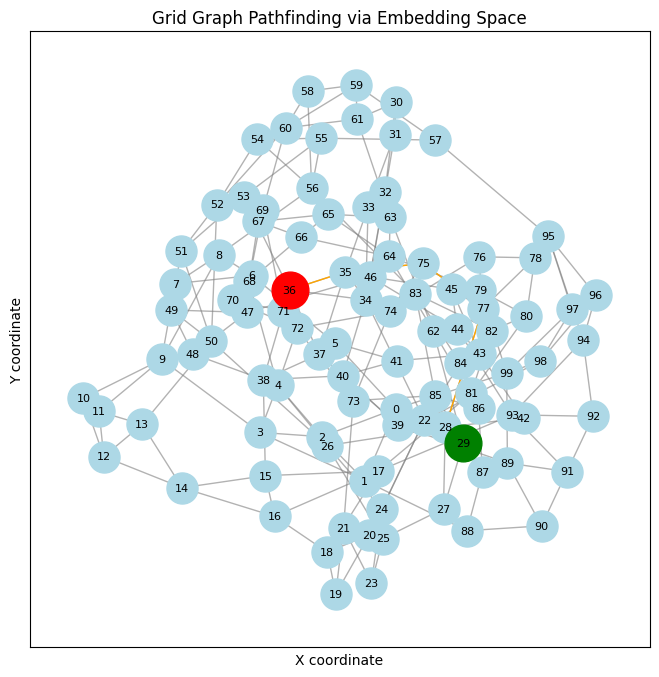

In [9]:
# 1. 创建一个随机图
G, adj = create_random_graph(num_nodes=100, k=4, p=0.2)

# 2. 使用 GAE 生成嵌入
embeddings = generate_embeddings_gae(G, method='gae', embedding_dim=32, hidden_dim=32, epochs=200, lr=0.01)

# 3. 随机选择起点和终点
nodes = list(G.nodes())
start_node = random.choice(nodes)
target_node = random.choice(nodes)
while start_node == target_node:
    target_node = random.choice(nodes)
    
print(f"\n开始路径搜索...")
print(f"起点: Node {start_node}")
print(f"终点: Node {target_node}")

# 4. 寻找路径
found_path = find_path_in_embedding_space(adj, embeddings, start_node, target_node)
shortest_path = nx.shortest_path(G, source=start_node, target=target_node)
print(f"\n搜索完成。")
print(f"找到的路径: {found_path}")

# 5. 可视化结果
print("正在计算可视化布局...")
pos = nx.spring_layout(G, seed=4)
visualize_path(G, pos, found_path, start_node, target_node)
visualize_path(G, pos, shortest_path, start_node, target_node)
